In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy')

print(psi.shape)

psi_one = psi[:, 0, :]  
print(psi_one.shape)
# # psi_one = psi_one[:, :]

psi_two = psi[:, 1, :]
# # psi_two  = psi_two[:, :]

psi = np.concatenate((psi_one, psi_two), axis=0)

print(psi.shape)

(299400, 2, 75)
(299400, 75)
(598800, 75)


In [3]:
# Pre-processing

lead = 1

trainN = 200000
valN = 50000
index = 63


print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi



psi_train_input = torch.tensor(psi[1:trainN + 1,:])
psi_train_label =  torch.tensor(psi[1 + lead:trainN+lead + 1,:])
###Changed to include prior state
psi_memory = torch.tensor(psi[0:trainN, :])

psi_val_input = torch.tensor(psi[trainN + 5: trainN + valN + 5,:])
psi_val_label =  torch.tensor(psi[trainN + lead + 5 : trainN + valN + lead + 5,:])
### Same as above
psi_memory_val = torch.tensor(psi[trainN + 4 : trainN + valN + 4, :])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)
print(psi_memory.shape)

#Total Variation Integral
def total_variation_distance(p,q):
	p = np.array(p)
	q = np.array(q)
	return 0.5 * np.sum(np.abs(p-q))

# #actual implementation
# pred_hist, _ = np.histogram(predictions, bins=50, density=True)
# actual_hist, _ = np.histogram(actual_values,bins=50,density=True)

# tvd = total_variation_distance(pred_hist,actual_hist)


(598800, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])
torch.Size([200000, 75])


(598800, 75)


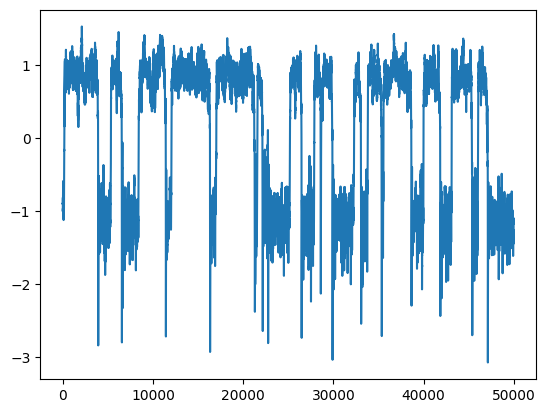

In [4]:
print(psi.shape)
# plt.plot(psi_train_input[0:200000,63])
plt.plot(psi_val_input[0:200000,63])


In [ ]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, prev_elem):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim + prev_elem, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition, prev_element):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition 
        z = torch.cat((z, prev_element), dim = 1)
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim, prev_elem):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, prev_elem)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
#I need to put the prev_elem (X(t - 1)) in the latent space that is passed to 
#the decoder to recontruct an output (X(t + 1)).
    def decode(self, z, condition, prev_elem):
        return self.decoder(z, condition, prev_elem)

    def forward(self, x, condition, prev_elem):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition, prev_elem)
        return output, mu, logvar


Epoch 1, 
          Reconstrunction Loss: 3141.112060546875,
          KL Divergence Lwss: 1073.1063232421875

          Validation Reconstrunction Loss: 9284.9736328125,
          Validation KL Divergence Loss: 3056.34765625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


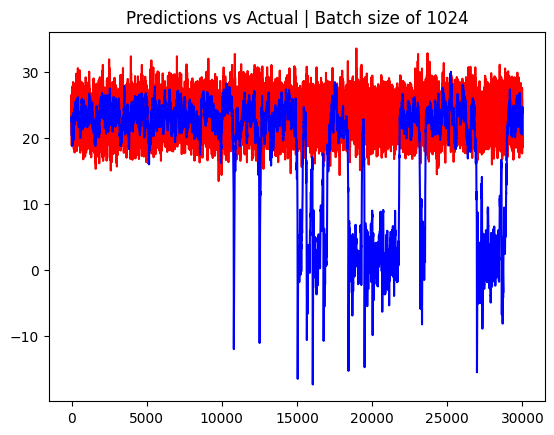

Epoch 2, 
          Reconstrunction Loss: 1597.347900390625,
          KL Divergence Lwss: 545.153564453125

          Validation Reconstrunction Loss: 4670.26318359375,
          Validation KL Divergence Loss: 1559.3359375
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


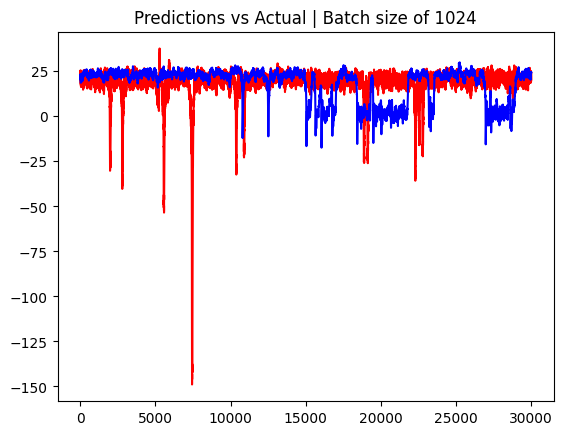

Epoch 3, 
          Reconstrunction Loss: 1173.91650390625,
          KL Divergence Lwss: 364.0787353515625

          Validation Reconstrunction Loss: 3267.489990234375,
          Validation KL Divergence Loss: 1036.8277587890625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


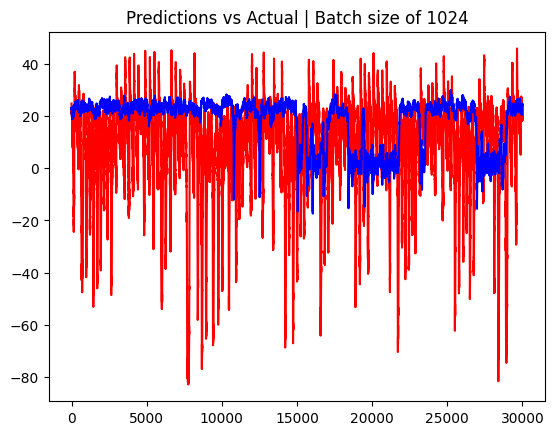

Epoch 4, 
          Reconstrunction Loss: 917.6998291015625,
          KL Divergence Lwss: 271.1424560546875

          Validation Reconstrunction Loss: 2588.80322265625,
          Validation KL Divergence Loss: 768.29150390625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


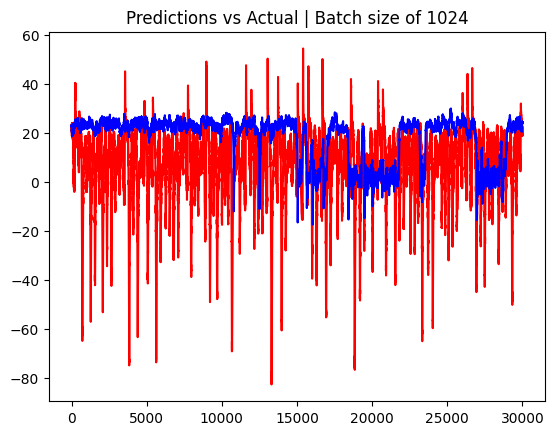

Epoch 5, 
          Reconstrunction Loss: 787.9476928710938,
          KL Divergence Lwss: 212.12042236328125

          Validation Reconstrunction Loss: 2078.130126953125,
          Validation KL Divergence Loss: 601.127685546875
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


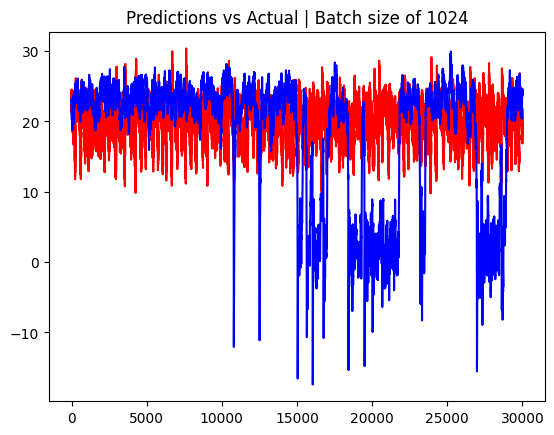

Epoch 6, 
          Reconstrunction Loss: 637.93994140625,
          KL Divergence Lwss: 171.47674560546875

          Validation Reconstrunction Loss: 1684.5841064453125,
          Validation KL Divergence Loss: 486.77911376953125
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


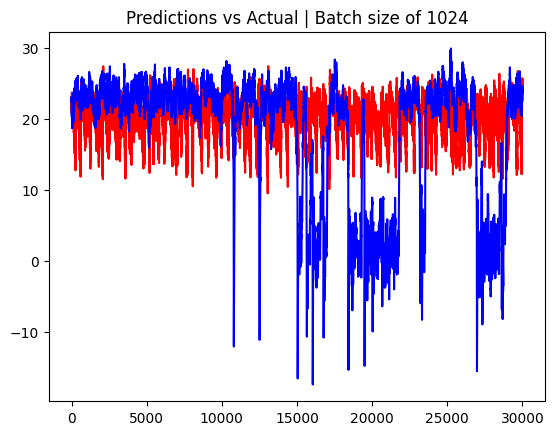

Epoch 7, 
          Reconstrunction Loss: 540.7705688476562,
          KL Divergence Lwss: 142.24778747558594

          Validation Reconstrunction Loss: 1483.802978515625,
          Validation KL Divergence Loss: 404.03253173828125
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


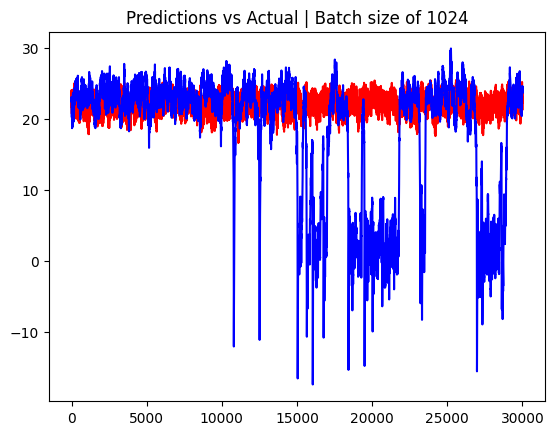

Epoch 8, 
          Reconstrunction Loss: 453.05316162109375,
          KL Divergence Lwss: 120.52618408203125

          Validation Reconstrunction Loss: 1204.2994384765625,
          Validation KL Divergence Loss: 341.16339111328125
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


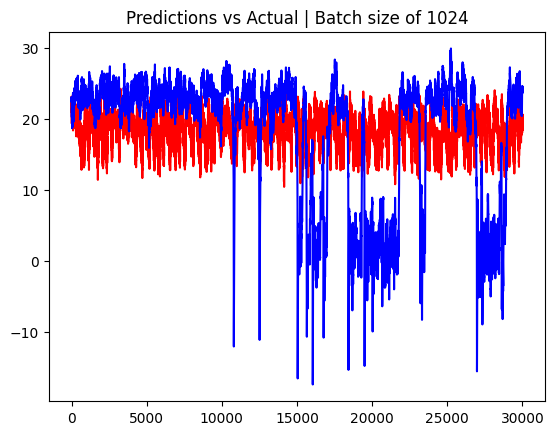

Epoch 9, 
          Reconstrunction Loss: 415.8082275390625,
          KL Divergence Lwss: 103.74601745605469

          Validation Reconstrunction Loss: 1144.6676025390625,
          Validation KL Divergence Loss: 292.46502685546875
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


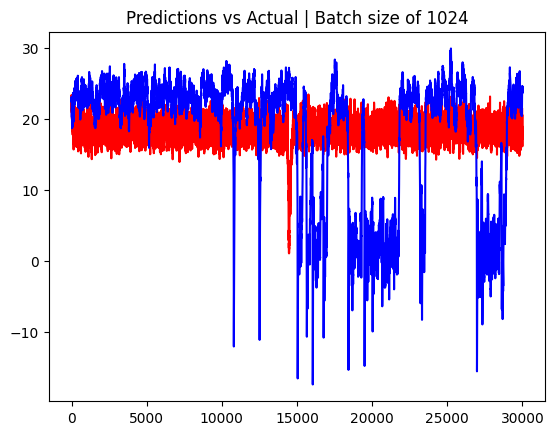

Epoch 10, 
          Reconstrunction Loss: 503.8782958984375,
          KL Divergence Lwss: 93.91963195800781

          Validation Reconstrunction Loss: 1337.9620361328125,
          Validation KL Divergence Loss: 260.6734313964844
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


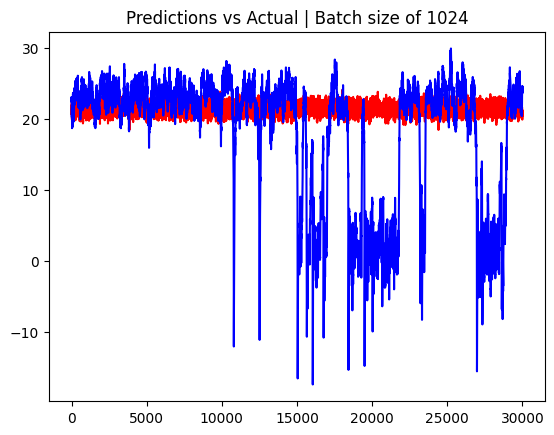

Epoch 11, 
          Reconstrunction Loss: 421.05474853515625,
          KL Divergence Lwss: 83.04562377929688

          Validation Reconstrunction Loss: 1066.135498046875,
          Validation KL Divergence Loss: 227.69781494140625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


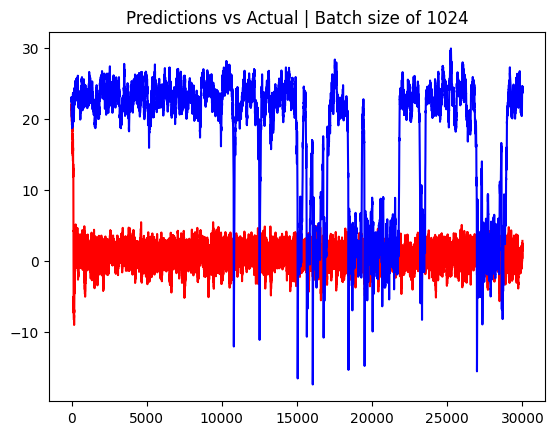

Epoch 12, 
          Reconstrunction Loss: 465.8169250488281,
          KL Divergence Lwss: 83.5531005859375

          Validation Reconstrunction Loss: 1309.085693359375,
          Validation KL Divergence Loss: 218.9410400390625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


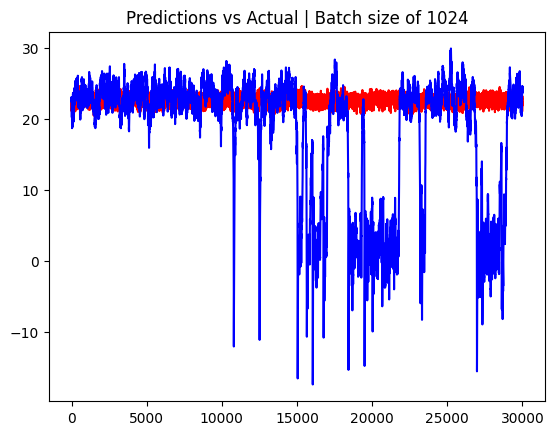

Epoch 13, 
          Reconstrunction Loss: 340.10479736328125,
          KL Divergence Lwss: 64.94729614257812

          Validation Reconstrunction Loss: 889.4425048828125,
          Validation KL Divergence Loss: 173.2853546142578
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


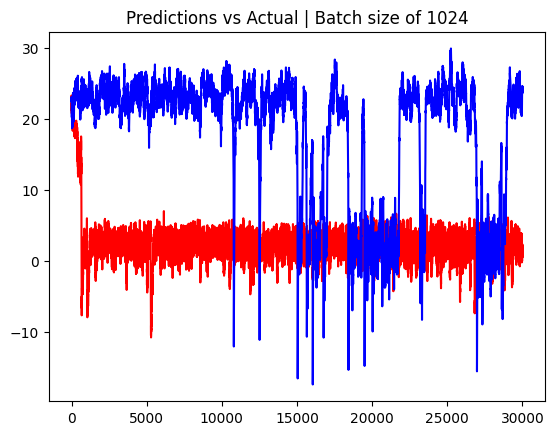

Epoch 14, 
          Reconstrunction Loss: 295.82647705078125,
          KL Divergence Lwss: 57.15719223022461

          Validation Reconstrunction Loss: 798.8920288085938,
          Validation KL Divergence Loss: 153.25006103515625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


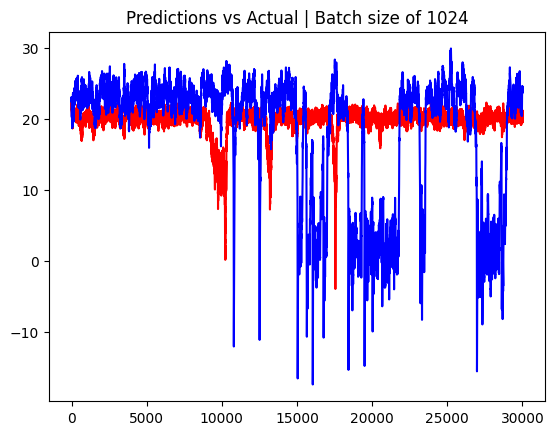

Epoch 15, 
          Reconstrunction Loss: 282.92779541015625,
          KL Divergence Lwss: 65.65589904785156

          Validation Reconstrunction Loss: 726.3743286132812,
          Validation KL Divergence Loss: 163.18035888671875
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


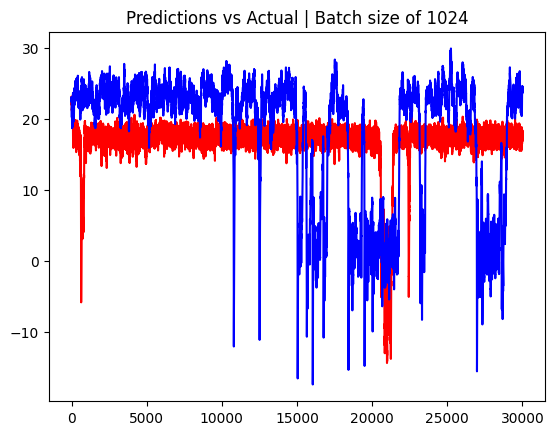

Epoch 16, 
          Reconstrunction Loss: 293.2900390625,
          KL Divergence Lwss: 62.628875732421875

          Validation Reconstrunction Loss: 794.6639404296875,
          Validation KL Divergence Loss: 150.94090270996094
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


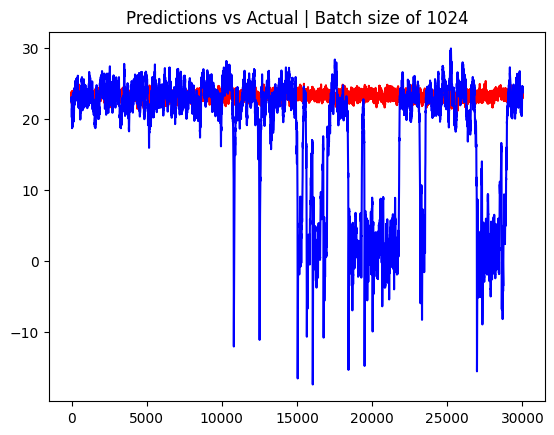

Epoch 17, 
          Reconstrunction Loss: 394.98797607421875,
          KL Divergence Lwss: 41.38438415527344

          Validation Reconstrunction Loss: 1094.5576171875,
          Validation KL Divergence Loss: 104.32180786132812
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


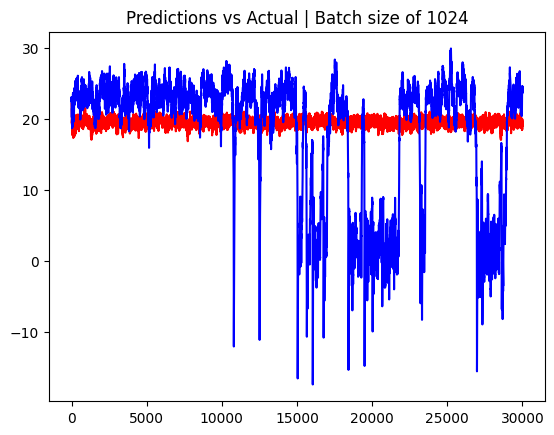

Epoch 18, 
          Reconstrunction Loss: 239.62115478515625,
          KL Divergence Lwss: 59.257606506347656

          Validation Reconstrunction Loss: 615.4306640625,
          Validation KL Divergence Loss: 129.6610565185547
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


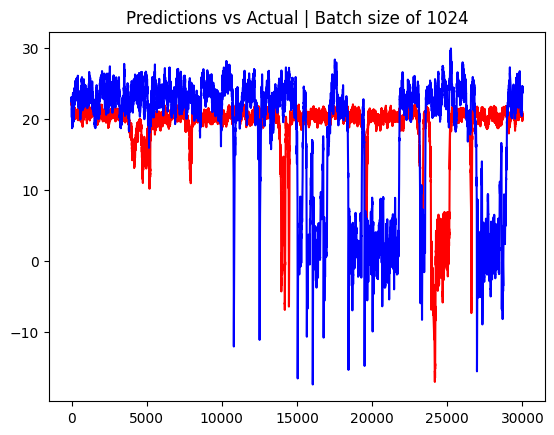

Epoch 19, 
          Reconstrunction Loss: 278.4212646484375,
          KL Divergence Lwss: 34.87604522705078

          Validation Reconstrunction Loss: 658.3382568359375,
          Validation KL Divergence Loss: 87.49590301513672
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


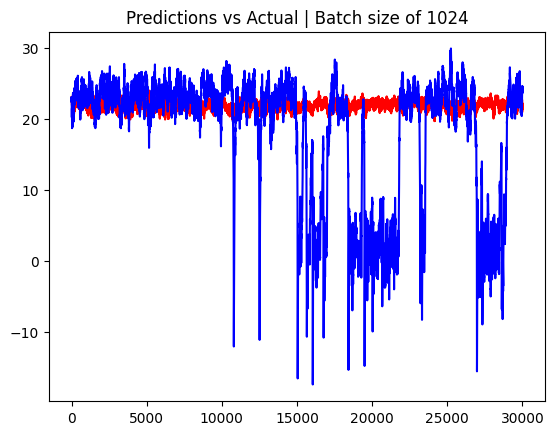

Epoch 20, 
          Reconstrunction Loss: 295.1865234375,
          KL Divergence Lwss: 39.0750846862793

          Validation Reconstrunction Loss: 808.1644897460938,
          Validation KL Divergence Loss: 92.78041076660156
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


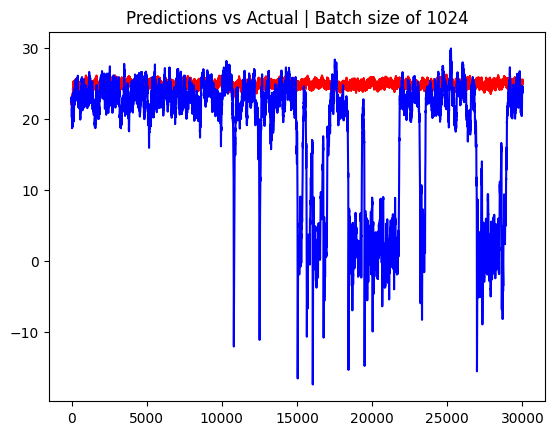

Epoch 21, 
          Reconstrunction Loss: 186.8528289794922,
          KL Divergence Lwss: 34.94734191894531

          Validation Reconstrunction Loss: 496.0205078125,
          Validation KL Divergence Loss: 80.95127868652344
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


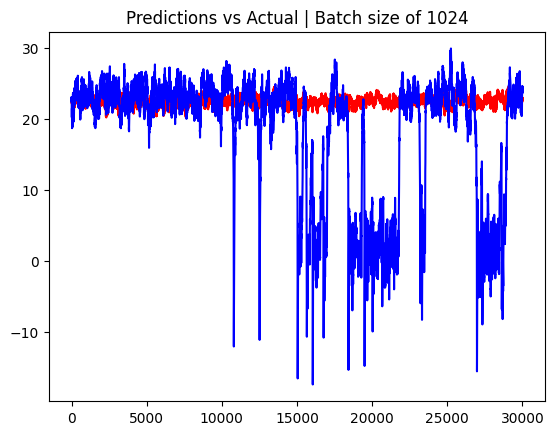

Epoch 22, 
          Reconstrunction Loss: 271.8079833984375,
          KL Divergence Lwss: 25.232929229736328

          Validation Reconstrunction Loss: 744.8782958984375,
          Validation KL Divergence Loss: 61.564666748046875
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


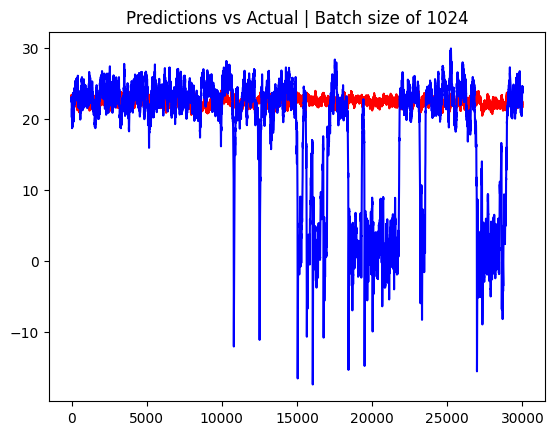

Epoch 23, 
          Reconstrunction Loss: 194.65969848632812,
          KL Divergence Lwss: 35.900447845458984

          Validation Reconstrunction Loss: 506.08038330078125,
          Validation KL Divergence Loss: 80.787353515625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


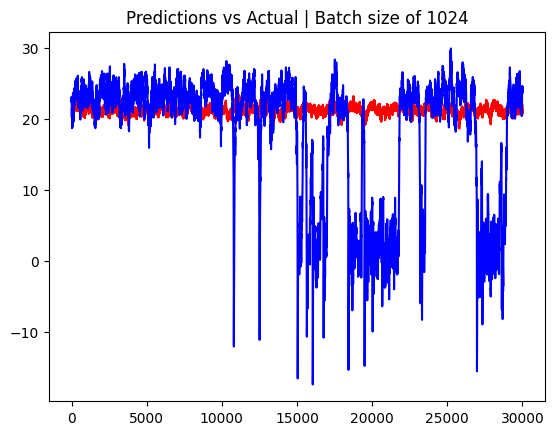

Epoch 24, 
          Reconstrunction Loss: 200.6376953125,
          KL Divergence Lwss: 20.34596824645996

          Validation Reconstrunction Loss: 508.4130859375,
          Validation KL Divergence Loss: 49.057029724121094
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


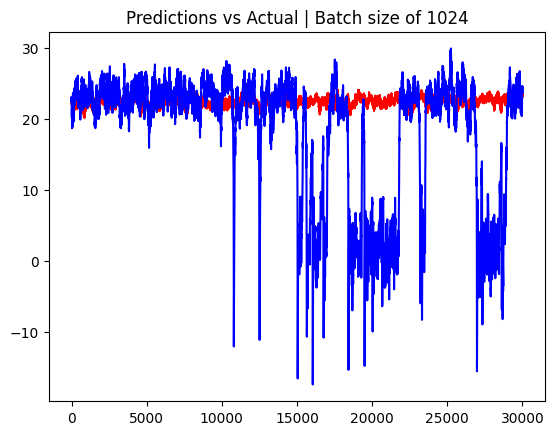

Epoch 25, 
          Reconstrunction Loss: 242.334228515625,
          KL Divergence Lwss: 39.533905029296875

          Validation Reconstrunction Loss: 658.0062866210938,
          Validation KL Divergence Loss: 82.46488952636719
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


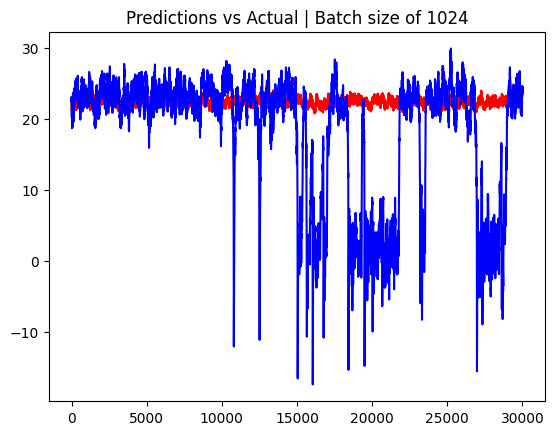

Epoch 26, 
          Reconstrunction Loss: 205.6112060546875,
          KL Divergence Lwss: 17.651037216186523

          Validation Reconstrunction Loss: 490.2540588378906,
          Validation KL Divergence Loss: 44.573665618896484
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


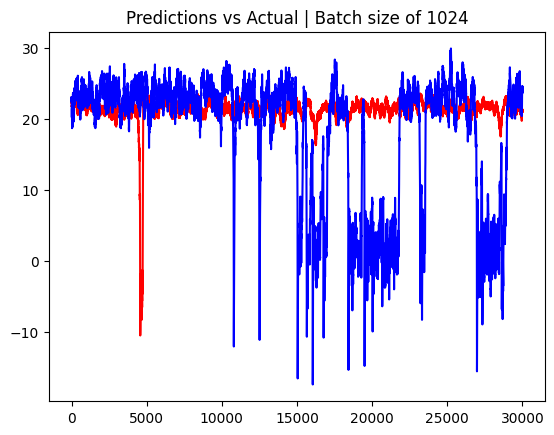

Epoch 27, 
          Reconstrunction Loss: 193.7486572265625,
          KL Divergence Lwss: 16.800567626953125

          Validation Reconstrunction Loss: 511.0680236816406,
          Validation KL Divergence Loss: 38.30223846435547
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


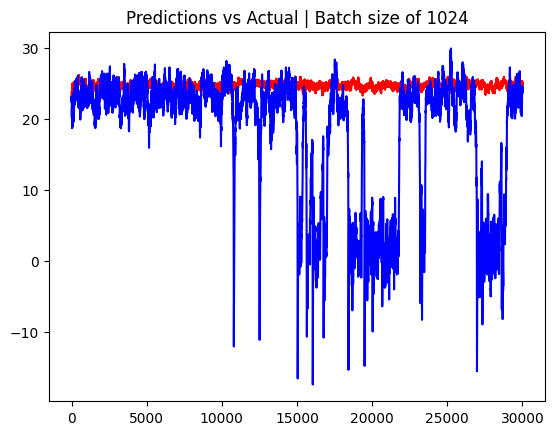

Epoch 28, 
          Reconstrunction Loss: 210.28834533691406,
          KL Divergence Lwss: 17.69179916381836

          Validation Reconstrunction Loss: 534.771240234375,
          Validation KL Divergence Loss: 40.59257507324219
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


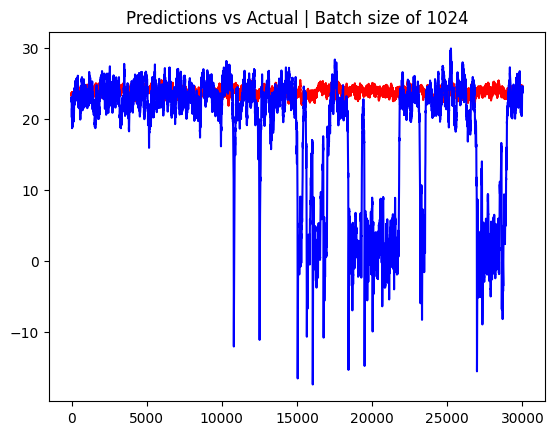

Epoch 29, 
          Reconstrunction Loss: 150.88690185546875,
          KL Divergence Lwss: 23.58411979675293

          Validation Reconstrunction Loss: 385.83953857421875,
          Validation KL Divergence Loss: 55.71338653564453
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


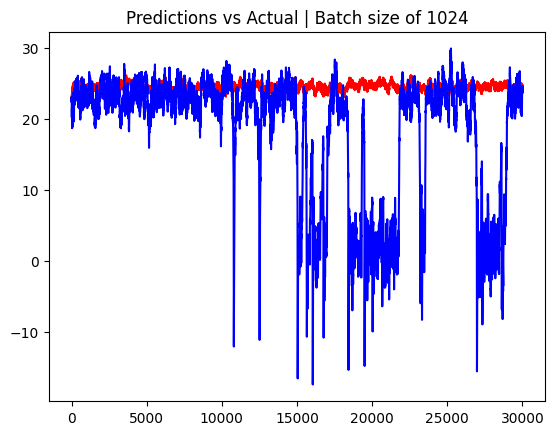

Epoch 30, 
          Reconstrunction Loss: 167.55609130859375,
          KL Divergence Lwss: 12.82606315612793

          Validation Reconstrunction Loss: 421.56890869140625,
          Validation KL Divergence Loss: 28.528459548950195
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


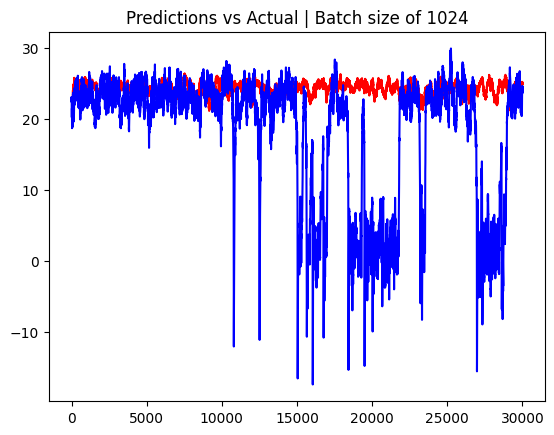

Epoch 31, 
          Reconstrunction Loss: 197.81246948242188,
          KL Divergence Lwss: 12.586076736450195

          Validation Reconstrunction Loss: 496.5474853515625,
          Validation KL Divergence Loss: 28.941299438476562
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


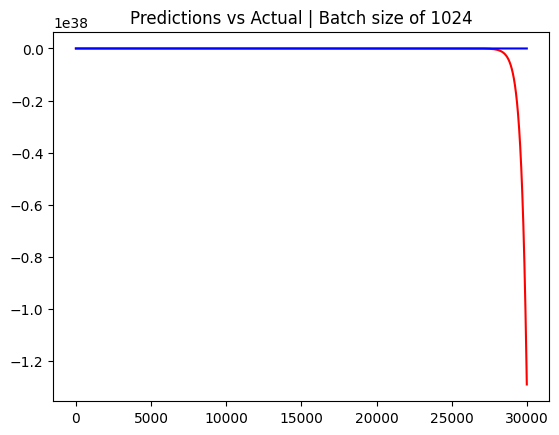

Epoch 32, 
          Reconstrunction Loss: 279.4980773925781,
          KL Divergence Lwss: 24.818004608154297

          Validation Reconstrunction Loss: 742.47607421875,
          Validation KL Divergence Loss: 58.98611068725586
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


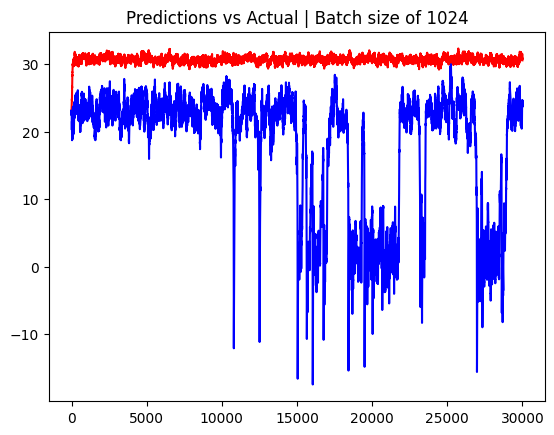

Epoch 33, 
          Reconstrunction Loss: 130.15115356445312,
          KL Divergence Lwss: 10.277055740356445

          Validation Reconstrunction Loss: 342.06988525390625,
          Validation KL Divergence Loss: 23.783151626586914
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


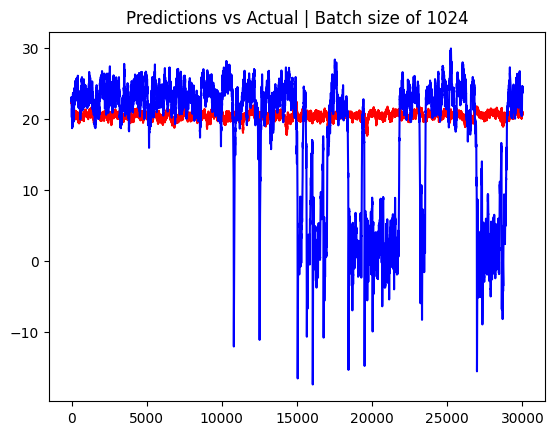

Epoch 34, 
          Reconstrunction Loss: 258.40533447265625,
          KL Divergence Lwss: 19.834054946899414

          Validation Reconstrunction Loss: 648.9976806640625,
          Validation KL Divergence Loss: 42.954002380371094
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


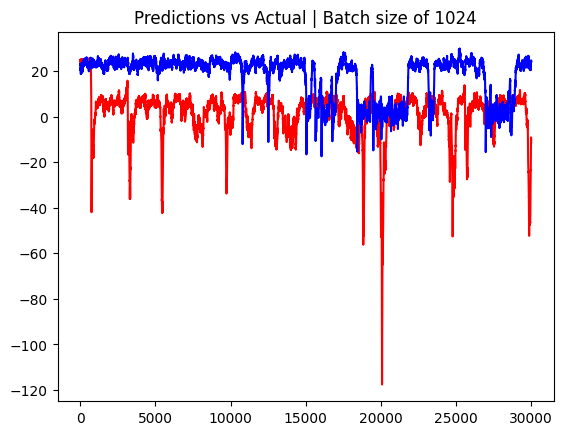

Epoch 35, 
          Reconstrunction Loss: 119.38249969482422,
          KL Divergence Lwss: 7.5593719482421875

          Validation Reconstrunction Loss: 317.4808349609375,
          Validation KL Divergence Loss: 17.82574462890625
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


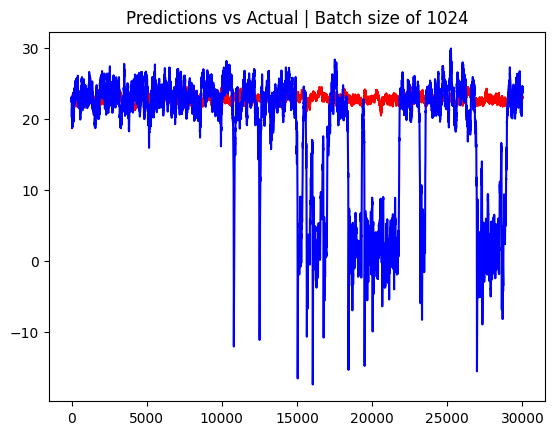

Epoch 36, 
          Reconstrunction Loss: 145.67686462402344,
          KL Divergence Lwss: 14.31801700592041

          Validation Reconstrunction Loss: 379.58673095703125,
          Validation KL Divergence Loss: 28.724803924560547
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


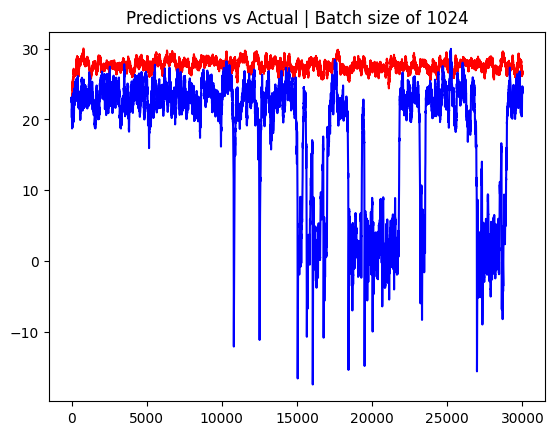

Epoch 37, 
          Reconstrunction Loss: 148.6627655029297,
          KL Divergence Lwss: 7.920377731323242

          Validation Reconstrunction Loss: 386.7589111328125,
          Validation KL Divergence Loss: 19.287918090820312
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


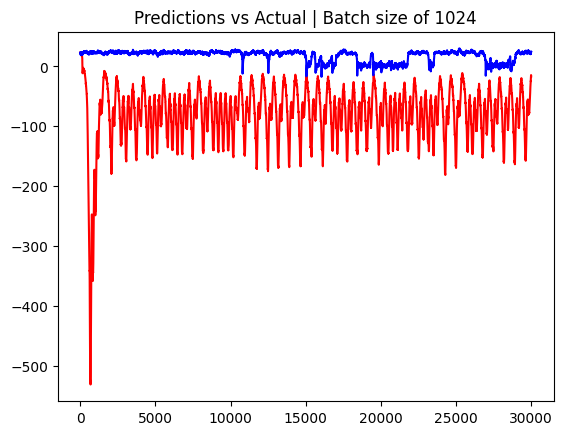

Epoch 38, 
          Reconstrunction Loss: 169.6103057861328,
          KL Divergence Lwss: 7.478805065155029

          Validation Reconstrunction Loss: 425.3037109375,
          Validation KL Divergence Loss: 15.420432090759277
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


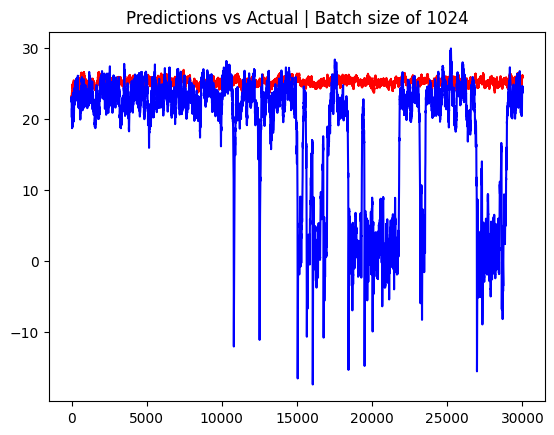

Epoch 39, 
          Reconstrunction Loss: 178.76318359375,
          KL Divergence Lwss: 6.24445104598999

          Validation Reconstrunction Loss: 455.64434814453125,
          Validation KL Divergence Loss: 14.854029655456543
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


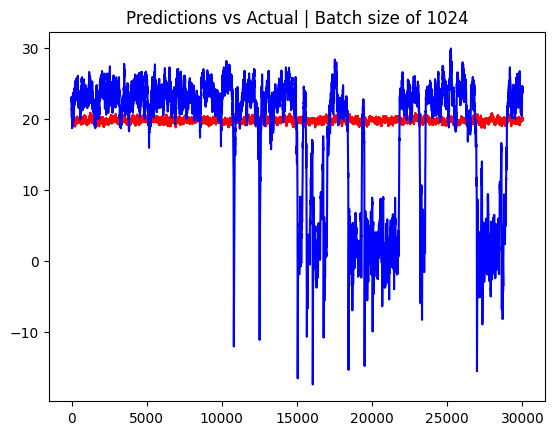

Epoch 40, 
          Reconstrunction Loss: 217.78924560546875,
          KL Divergence Lwss: 19.537078857421875

          Validation Reconstrunction Loss: 528.138427734375,
          Validation KL Divergence Loss: 37.64714050292969
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


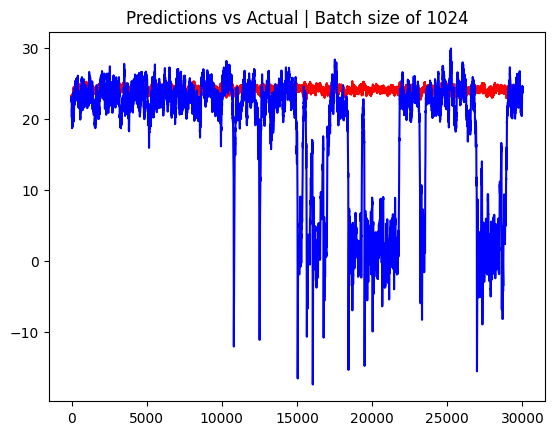

Epoch 41, 
          Reconstrunction Loss: 106.69271850585938,
          KL Divergence Lwss: 5.385035514831543

          Validation Reconstrunction Loss: 291.20074462890625,
          Validation KL Divergence Loss: 13.361649513244629
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


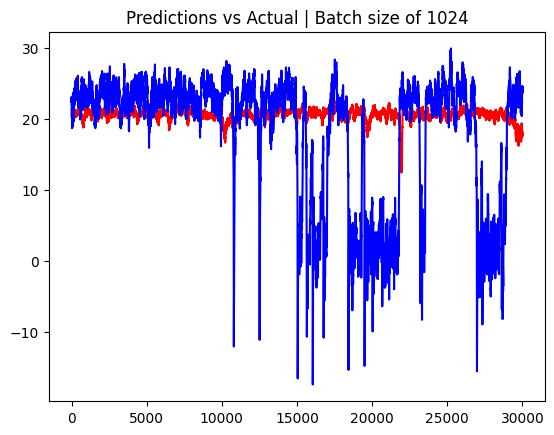

Epoch 42, 
          Reconstrunction Loss: 161.84310913085938,
          KL Divergence Lwss: 13.727598190307617

          Validation Reconstrunction Loss: 398.60552978515625,
          Validation KL Divergence Loss: 27.468181610107422
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


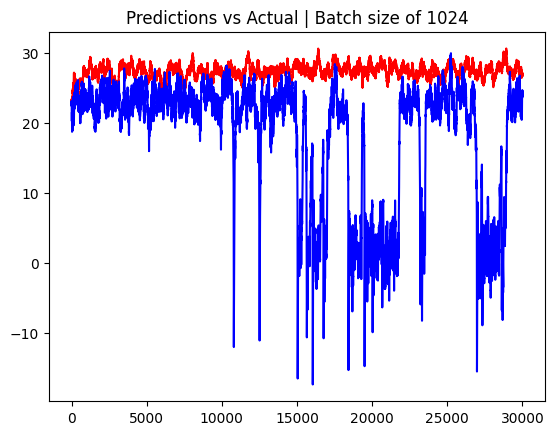

Epoch 43, 
          Reconstrunction Loss: 143.0470733642578,
          KL Divergence Lwss: 4.577834129333496

          Validation Reconstrunction Loss: 364.71875,
          Validation KL Divergence Loss: 11.048566818237305
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


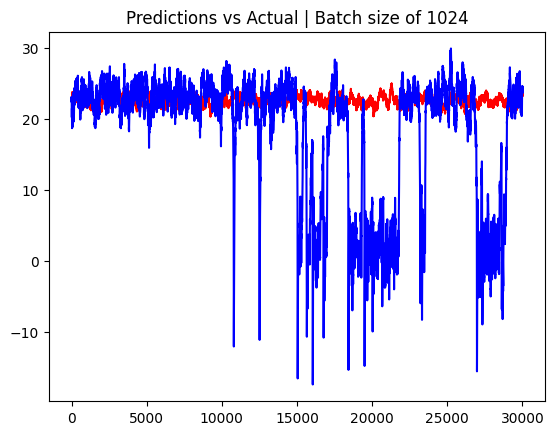

Epoch 44, 
          Reconstrunction Loss: 147.288330078125,
          KL Divergence Lwss: 10.493131637573242

          Validation Reconstrunction Loss: 361.6919250488281,
          Validation KL Divergence Loss: 21.974414825439453
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


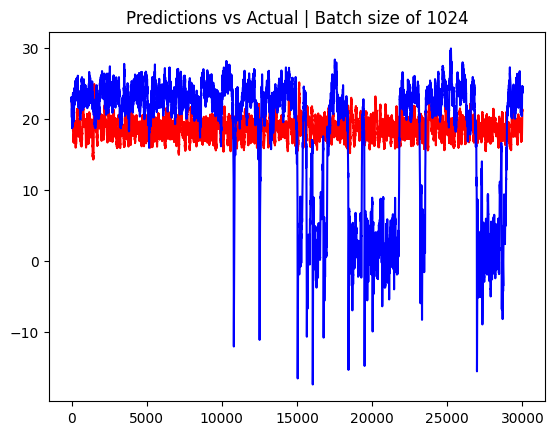

Epoch 45, 
          Reconstrunction Loss: 123.73002624511719,
          KL Divergence Lwss: 4.673762321472168

          Validation Reconstrunction Loss: 320.7790832519531,
          Validation KL Divergence Loss: 11.437641143798828
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


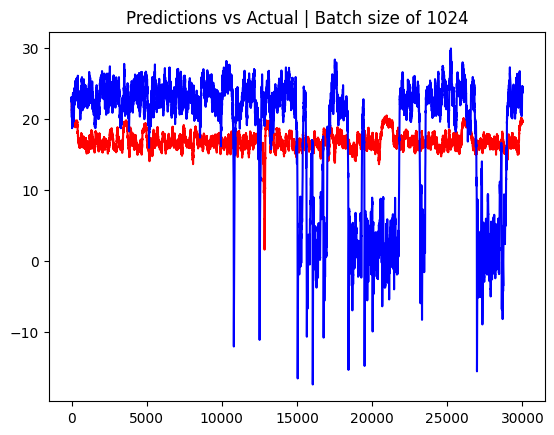

Epoch 46, 
          Reconstrunction Loss: 150.74530029296875,
          KL Divergence Lwss: 16.512937545776367

          Validation Reconstrunction Loss: 356.40582275390625,
          Validation KL Divergence Loss: 38.34990692138672
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


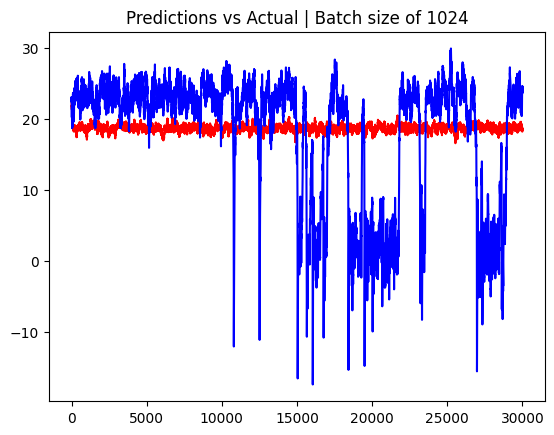

Epoch 47, 
          Reconstrunction Loss: 223.4314727783203,
          KL Divergence Lwss: 4.916880130767822

          Validation Reconstrunction Loss: 523.9398193359375,
          Validation KL Divergence Loss: 11.777711868286133
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


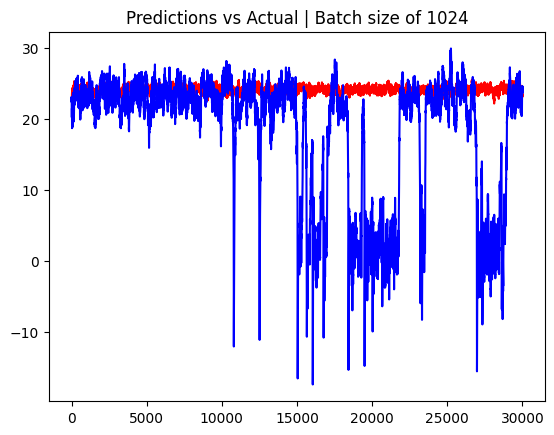

Epoch 48, 
          Reconstrunction Loss: 105.5753173828125,
          KL Divergence Lwss: 9.711666107177734

          Validation Reconstrunction Loss: 275.4202880859375,
          Validation KL Divergence Loss: 22.34164810180664
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


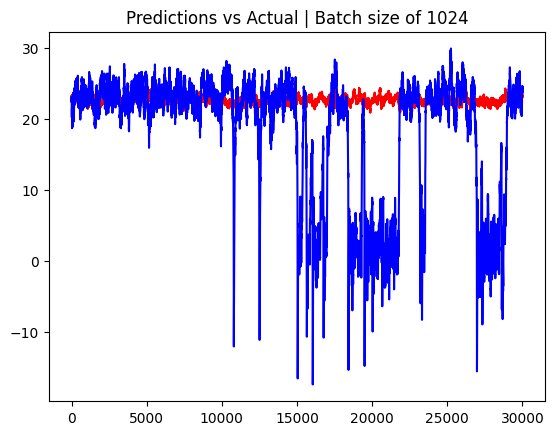

Epoch 49, 
          Reconstrunction Loss: 144.29434204101562,
          KL Divergence Lwss: 4.368128299713135

          Validation Reconstrunction Loss: 382.4925231933594,
          Validation KL Divergence Loss: 10.982969284057617
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


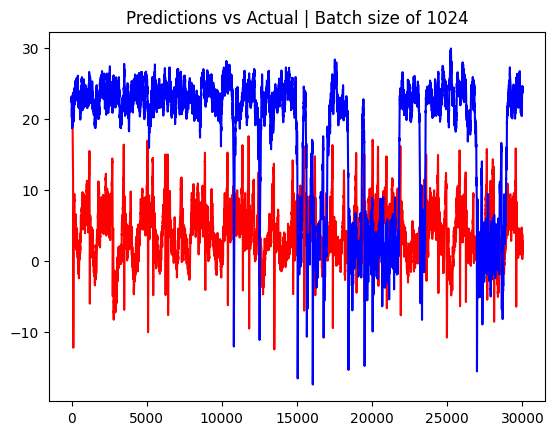

Epoch 50, 
          Reconstrunction Loss: 93.09782409667969,
          KL Divergence Lwss: 19.478464126586914

          Validation Reconstrunction Loss: 252.11624145507812,
          Validation KL Divergence Loss: 46.689208984375
[10.55404332]
tensor([23.0207, 22.9245, 22.5899,  ..., 23.9619, 23.9700, 24.2705],
       dtype=torch.float64)


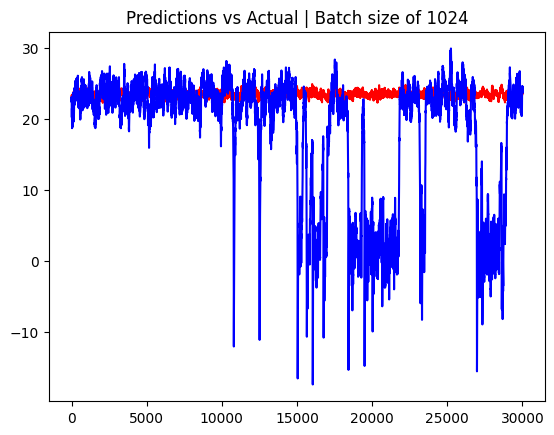

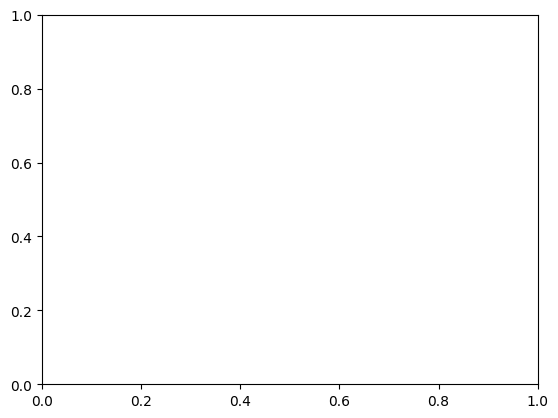

In [7]:


input_dim = 1
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 50
prev_elem = 75

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, prev_elem)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    for batch in range (2, trainN, batch_size):

        ### Changed here to include the previous element in batching samples
        prev_element = psi_memory[batch:batch + batch_size,:]


        input_batch = psi_train_input[batch:batch + batch_size,:]
        label_batch = psi_train_label[batch:batch + batch_size,:]
        optimizer.zero_grad()


        ### Changed here to pass the previous element to the Decoder to reconstruct using the previous states  ###
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())

        # Reconstruction loss
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        # KL divergence loss
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
        # Total loss
        loss = reconstruction_loss + 10 * kl_loss

        loss.backward()
        optimizer.step()

    print(f'''Epoch {epoch+1}, 
          Reconstrunction Loss: {reconstruction_loss},
          KL Divergence Lwss: {kl_loss}''')

    # Validation Loss
    for batch in range (0, valN, batch_size):
        
        ### Same as before but for the validiation set ###
        prev_element = psi_memory_val[batch:batch + batch_size,:]

        input_batch = psi_val_input[batch:batch + batch_size,:]
        label_batch = psi_val_label[batch:batch + batch_size,:]
        
        ### Same as before but for the validation set ### 
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        val_loss = reconstruction_loss + 10 * kl_loss # Experiment HIGHER coefficients
        # Print both reconstruction_loss and kl_loss

    print(f'''
          Validation Reconstrunction Loss: {reconstruction_loss},
          Validation KL Divergence Loss: {kl_loss}''')

    # Inference

    ### Changed here to use the x(t) and x(t - 1) as ground truth elements
    initial_cond = torch.reshape(torch.tensor(psi[1,:]), [1, 75])
    preveious_elem = torch.reshape(torch.tensor(psi[0,:]), [1, 75])

    time_step = 30000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)

                ### Change here passes the X(t - 1) to the initial condition
                y = (model.decode(z.float().cuda(), initial_cond.float().cuda(), preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                preveious_elem = initial_cond
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                ### Change here same as above
                input_element = torch.reshape(torch.tensor(pred[k-1,:,select_ens]), [1,75]).float().cuda()

                y = (model.decode(z.float().cuda(), input_element, preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                preveious_elem = initial_cond
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])
                ### Change here to use X(t - 1) as previous element in next pred


    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    plt.plot(pred_mean[0:30000,63],'r')
    plt.plot(actual_values[0:30000],'b')
    plt.title(f"Predictions vs Actual | Batch size of {batch_size}")
    plt.show()
    plt.cla()